In [31]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.spectra.spectrum1d import Spectrum1D
from specutils.fitting.continuum import fit_generic_continuum
from specutils.fitting import fit_lines
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.nddata.nduncertainty import StdDevUncertainty
from specutils.manipulation import gaussian_smooth
from scipy.signal import correlate

In [32]:
f = h5py.File('20240521_0000007.h5', 'r')
dset=f['MatSpectra']

In [33]:
def normalise_and_plot(no, plot_continuum=False, ret=False, plot_spec=True):
    
    x=np.arange(3470, 3470 + 1036 * 2, 2)
    spectrum = Spectrum1D(flux=dset[no][9] * u.Jy, spectral_axis=x * u.um)

    fitted_continuum = fit_generic_continuum(spectrum=spectrum,model=Linear1D(),fitter=LinearLSQFitter())
    y_fit = fitted_continuum(x*u.um)
    normed = spectrum / y_fit
    
    if plot_continuum==True:
        fig,ax=plt.subplots(figsize=(10,3))
        ax.plot(x,dset[no][9],color='black')
        ax.plot(x,y_fit,color='red',linewidth=2)
        ax.fill_between(x,dset[no][9]+dset[no][3],dset[no][9]-dset[no][3],color='dimgrey',alpha=0.5,interpolate=False)
        ax.set_xlabel('\u00C5')
        ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")
    
    if plot_spec==True:
        fig,ax=plt.subplots(figsize=(10,3))
        ax.plot(normed.spectral_axis,normed.flux,color='black')
        ax.fill_between(x,(dset[no][9]+dset[no][3])/y_fit,(dset[no][9]-dset[no][3])/y_fit,color='dimgrey',alpha=0.5,interpolate=False)
        ax.set_xlabel('\u00C5')
        ax.set_title(f"RA={dset[no][8]:.2f}, DEC={dset[no][2]:.2f}")
    
    if ret==True:
        
        return normed.spectral_axis, normed.flux, y_fit

In [34]:
dat =  np.array([normalise_and_plot(i,plot_continuum=False,plot_spec=False,ret=True) for i in range(6)])
spaxes= dat[:,0]
fluxes=dat[:,1]
yfits=dat[:,2]

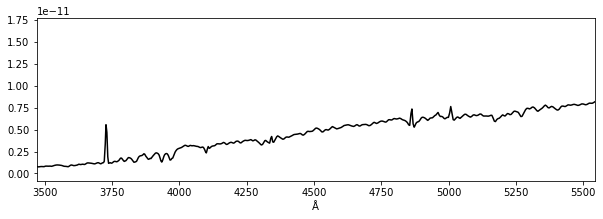

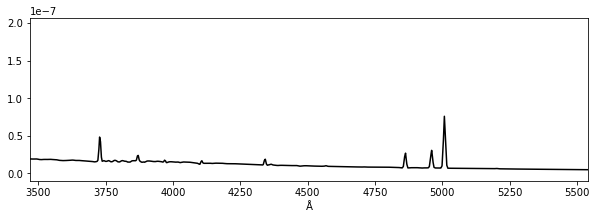

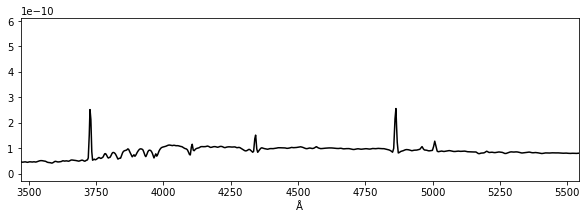

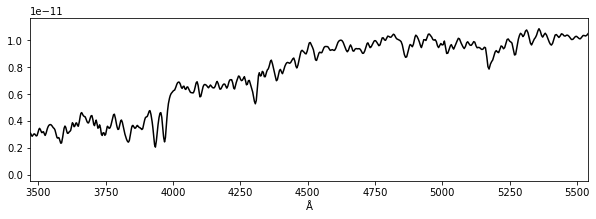

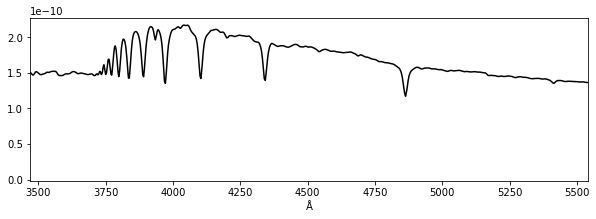

In [35]:
with h5py.File('template_spectra.hdf5','r') as h5:
    wavelength = h5['wavelength'][()]
    flux = h5['amplitudes'][()]
    
for i in range(5):
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot(wavelength,flux[i],color='black')
    ax.set_xlim(3470, 3470 + 1036 * 2)
    ax.set_xlabel('\u00C5')

1.6915164e-11
16188
1.9709884e-07
117
5.839536e-10
16188


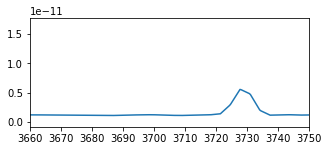

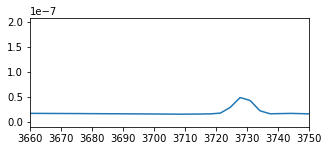

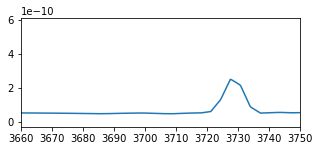

In [37]:
for i in range(3):
    fig,ax=plt.subplots(figsize=(5,2))
    #plt.scatter(wavelength,flux[i])
    plt.plot(wavelength,flux[i])
    print(max(flux[i]))
    print(np.argmax(flux[i]))
    ax.set_xlim(3660, 3750)

3727.6812


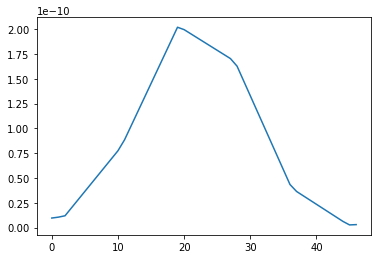

In [72]:
# Extract the O-II Lines

template=flux[2][(wavelength>3720.5) & (wavelength<3738)]-0.5e-10
plt.plot(template)
print(wavelength[(wavelength>3720.5) & (wavelength<3738)][np.argmax(template)])

In [77]:
## Append empirically determined negativa values on either side to offset the continuum

def filt(template, left, right):
    return np.concatenate((left*np.ones(20),template,right*np.ones(20)))

template_const=filt(template,-0.7e-10,-0.7e-10)
template_inc=filt(template,-0.7e-10,-1e-10)

In [74]:
def doppler(x):
    
    return x*1.144, x*0.004

def to_x(l):
    return 0.5*l-1735

In [78]:
linecolors=['blue','green','red','cyan','magenta','yellow','black','darkorange']
lines=[5007,4959,3726,3729,6563,4861,3969,3934]

def mf(no, template, line_no=2, l=3727.6812, zoom=False):

    corr= correlate(fluxes[no],template,mode='same')
    
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot(corr,color='blue',linewidth=3)
    
    if line_no!=2:
        ax.axvspan(to_x(doppler(lines[line_no])[0]-doppler(lines[line_no])[1]),
                   to_x(doppler(lines[line_no])[0]+doppler(lines[iline_no])[1]),color=linecolors[line_no],alpha=0.1)
        
    else:
        ax.axvspan(to_x(doppler(lines[line_no])[0]-doppler(lines[line_no])[1]),
                   to_x(doppler(lines[line_no+1])[0]+doppler(lines[line_no+1])[1]),color=linecolors[line_no],alpha=0.1)
        
    if zoom==True:
        plt.xlim(300,500)
        
    return corr

In [ ]:
const=[0,2]
inc=[1,3,4,5]

for i in const:
    mf(i, template_const)
    mf(i, template_const, zoom=True)
    
for i in inc:
    mf(i, inc_const)

array([nan, nan, nan, ..., nan, nan, nan])

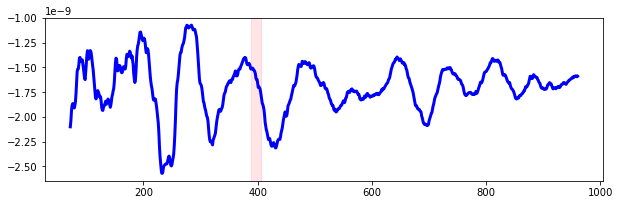

In [79]:
mf(0,template_const)